### Задача о предсказании цены акции компании Tesla на момент закрытия торгов

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import preprocessing
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import GRU, Dropout, SimpleRNN, LSTM, Dense

In [3]:
#Loading data
df = pd.read_csv('TSLA.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500
1,2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500
2,2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000
3,2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000
4,2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500
...,...,...,...,...,...,...,...
2951,2022-03-18,874.489990,907.849976,867.390015,905.390015,905.390015,33408500
2952,2022-03-21,914.979980,942.849976,907.090027,921.159973,921.159973,27327200
2953,2022-03-22,930.000000,997.859985,921.750000,993.979980,993.979980,35289500
2954,2022-03-23,979.940002,1040.699951,976.400024,999.109985,999.109985,40225400


In [5]:
#columns
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [7]:
#size datasets
df.shape

(2956, 7)

In [9]:
#check missing values
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2956 entries, 0 to 2955
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2956 non-null   object 
 1   Open       2956 non-null   float64
 2   High       2956 non-null   float64
 3   Low        2956 non-null   float64
 4   Close      2956 non-null   float64
 5   Adj Close  2956 non-null   float64
 6   Volume     2956 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 161.8+ KB


### Preprocessing and normalization data

In [14]:
#converting column data type Date to datetime
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2956 entries, 0 to 2955
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2956 non-null   datetime64[ns]
 1   Open       2956 non-null   float64       
 2   High       2956 non-null   float64       
 3   Low        2956 non-null   float64       
 4   Close      2956 non-null   float64       
 5   Adj Close  2956 non-null   float64       
 6   Volume     2956 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 161.8 KB


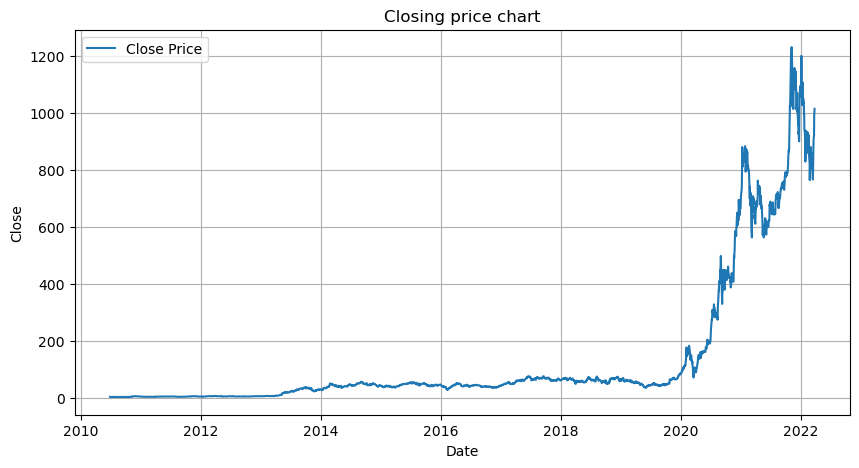

In [16]:
# Visualization Date vs Close
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Close'], label='Close Price', color='tab:blue')

plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Closing price chart')
plt.legend()
plt.grid(True)

plt.show()

In [18]:
# Data normalization
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(df.filter(['Close']))
# Scaled dataframe with 'close column'
df_scaled = pd.DataFrame(scaled, columns=['Close'])

In [20]:
df_scaled.describe()

,Close
count,2956.000000
mean,0.110538
std,0.203891
min,0.000000
25%,0.013413
50%,0.035366
75%,0.052940
max,1.000000


In [22]:
training_size = round(len(df) * 0.80) # 80% of data for training
training_size

2365

In [24]:
# Dividing the dataset into train and test
train_data = df_scaled[:training_size]
test_data  = df_scaled[training_size:]
train_data.shape, test_data.shape

((2365, 1), (591, 1))

In [26]:
# Function to create sequence of data for training and testing
def create_sequence(dataset):
  sequences = []
  labels = []
  start_idx = 0
  for stop_idx in range(60, len(dataset)):
    sequences.append(dataset.iloc[start_idx:stop_idx])
    labels.append(dataset.iloc[stop_idx])
    start_idx += 1
  return (np.array(sequences),np.array(labels))

In [28]:
train_seq, train_label = create_sequence(train_data)
test_seq, test_label = create_sequence(test_data)

In [30]:
#array dimensions for the training and test samples.
train_seq.shape, train_label.shape, test_seq.shape, test_label.shape

((2305, 60, 1), (2305, 1), (531, 60, 1), (531, 1))

### Simple RNN

In [33]:
RNN_model = Sequential([
    SimpleRNN(units=180, return_sequences=True, input_shape=(train_seq.shape[1],1), activation='tanh'),
    SimpleRNN(units=120, return_sequences= False, activation='tanh'),
    Dense(units=60),
    Dense(units=30),
    Dense(units=1)
])
RNN_model.summary()

C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 60, 180)        │        32,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 120)            │        36,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 60)             │         7,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,001 (304.69 KB)

 Trainable params: 78,001 (304.69 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
RNN_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [37]:
RNN_history = RNN_model.fit(train_seq, train_label, epochs=50, validation_data=(test_seq, test_label))

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.0893 - mean_absolute_error: 0.1423 - val_loss: 0.0278 - val_mean_absolute_error: 0.1385
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 2.5633e-05 - mean_absolute_error: 0.0039 - val_loss: 0.0231 - val_mean_absolute_error: 0.1280
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 4.9920e-05 - mean_absolute_error: 0.0054 - val_loss: 0.0153 - val_mean_absolute_error: 0.0999
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 3.9430e-05 - mean_absolute_error: 0.0051 - val_loss: 0.0123 - val_mean_absolute_error: 0.0908
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 1.8202e-05 - mean_absolute_error: 0.0034 - val_loss: 0.0091 - val_mean_absolute_error: 0.0772
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 1.5382e-05 - mean_absolute_error: 0.0032 - val_loss: 0.0065 - val_mean_absolute_error: 0.0641
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 2.0165e-05 - mean_absolute_

In [39]:
# Prediction for first 5 test sample
test_predicted1 = RNN_model.predict(test_seq)
test_predicted1[:5]

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


array([[0.12064527],
       [0.1265214 ],
       [0.12694232],
       [0.13609533],
       [0.13626032]], dtype=float32)

In [41]:
# Inverse transform
RNN_test_predicted = scaler.inverse_transform(test_predicted1) # Inversing scaling on predicted data
RNN_test_predicted[:5]

array([[151.16159],
       [158.37013],
       [158.8865 ],
       [170.11496],
       [170.31735]], dtype=float32)

In [43]:
# Inverse transform of test labels
RNN_labels_transform = scaler.inverse_transform(test_label)
RNN_labels_transform[:5]

array([[171.679993],
       [183.483994],
       [179.882004],
       [180.199997],
       [166.757996]])

[Text(0.5, 0, 'Epochs')]

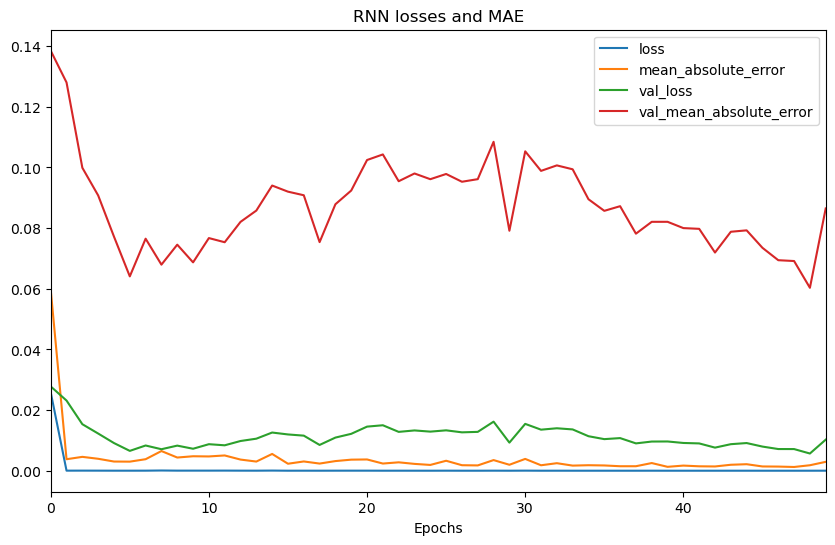

In [45]:
# Plot MAE and losses of val and train data
RNN_losses = pd.DataFrame(RNN_history.history)
ax1 = RNN_losses.plot(figsize=(10,6),title='RNN losses and MAE')
ax1.autoscale(axis='x',tight=True)
ax1.set(xlabel='Epochs')

In [47]:
# Score and error
print(f'Mean Absolute Error: {metrics.mean_absolute_error(RNN_labels_transform, RNN_test_predicted)}')
print(f'Mean Squared Error: {metrics.mean_squared_error(RNN_labels_transform, RNN_test_predicted)}')
print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(RNN_labels_transform, RNN_test_predicted))}')
print(f'R2_Score: {metrics.r2_score(RNN_labels_transform, RNN_test_predicted)}')

Mean Absolute Error: 106.1029218372368
Mean Squared Error: 15418.173319103591
Root Mean Squared Error: 124.16993725980372
R2_Score: 0.8202744110858229


In [49]:
# Create train and val data from DataFrame for visulaziation
train = df.filter(['Close'])[:2425]
valid = df.filter(['Close'])[2425:]
valid['RNN'] = RNN_test_predicted

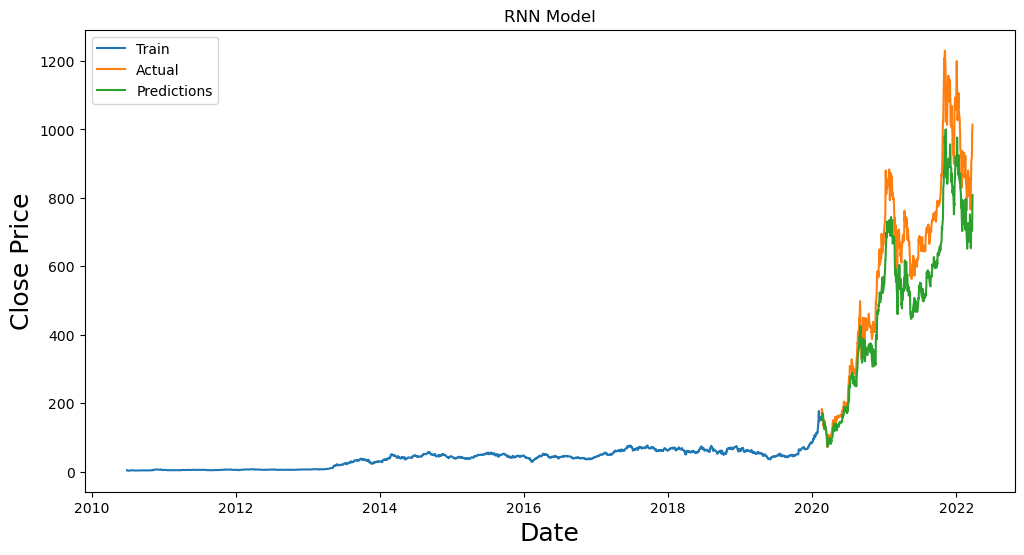

In [51]:
# Visualizing the data
plt.figure(figsize=(12, 6))
plt.title('RNN Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(df['Date'].iloc[:2425],train['Close'])
plt.plot(df['Date'].iloc[2425:],valid[['Close', 'RNN']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='best')
plt.show()

### LSTM

In [53]:
LSTM_model = Sequential([
    LSTM(units=180, return_sequences=True, input_shape=(train_seq.shape[1],1)),
    Dropout(0.2),
    LSTM(units=120, return_sequences= False),
    Dropout(0.2),
    Dense(units=60),
    Dropout(0.1),
    Dense(units=30),
    Dense(units=1)
])
LSTM_model.summary()

C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 180)        │       131,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 180)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 120)            │       144,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 60)             │         7,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 284,641 (1.09 MB)

 Trainable params: 284,641 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
LSTM_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [57]:
LSTM_history = LSTM_model.fit(train_seq, train_label, epochs=50, validation_data=(test_seq, test_label))

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step - loss: 3.7053e-04 - mean_absolute_error: 0.0132 - val_loss: 0.0021 - val_mean_absolute_error: 0.0316
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - loss: 1.0359e-05 - mean_absolute_error: 0.0025 - val_loss: 0.0031 - val_mean_absolute_error: 0.0410
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 9.4138e-06 - mean_absolute_error: 0.0024 - val_loss: 0.0024 - val_mean_absolute_error: 0.0344
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 9.4241e-06 - mean_absolute_error: 0.0024 - val_loss: 0.0028 - val_mean_absolute_error: 0.0383
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - loss: 7.9723e-06 - mean_absolute_error: 0.0022 - val_loss: 0.0028 - val_mean_absolute_error: 0.0392
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - loss: 9.8564e-06 - mean_absolute_error: 0.0024 - val_loss: 0.0018 - val_mean_absolute_error: 0.0298
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - loss: 7.8274e-06 -

In [59]:
# Prediction for test sample
test_predicted = LSTM_model.predict(test_seq)
test_predicted[:5]

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


array([[0.12294081],
       [0.12636147],
       [0.13209032],
       [0.136481  ],
       [0.13934705]], dtype=float32)

In [61]:
# Inverse transform
LSTM_test_predicted = scaler.inverse_transform(test_predicted) # Inversing scaling on predicted data
LSTM_test_predicted[:5]

array([[153.97765],
       [158.17395],
       [165.20181],
       [170.58809],
       [174.104  ]], dtype=float32)

In [63]:
# Inverse transform of test labels
LSTM_labels_transform = scaler.inverse_transform(test_label)
LSTM_labels_transform[:5]

array([[171.679993],
       [183.483994],
       [179.882004],
       [180.199997],
       [166.757996]])

[Text(0.5, 0, 'Epochs')]

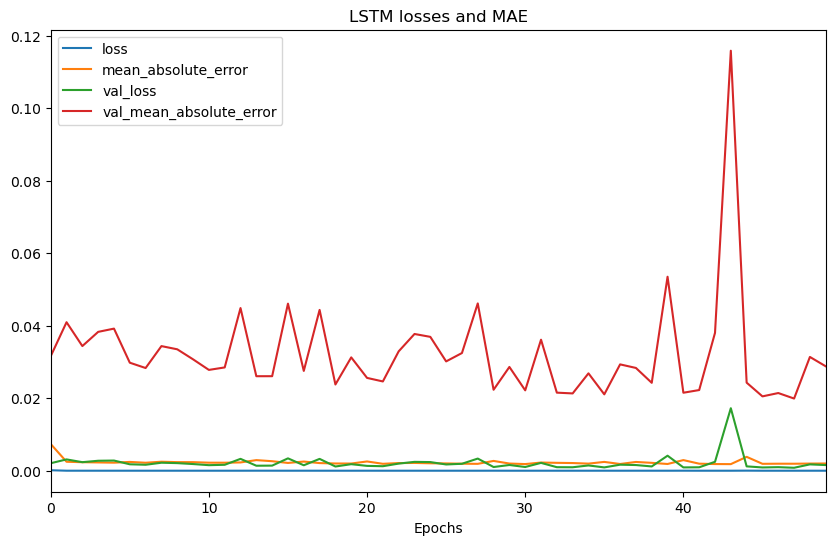

In [65]:
# Plot MAE and losses of val and train data
LSTM_losses = pd.DataFrame(LSTM_history.history)
ax = LSTM_losses.plot(figsize=(10,6),title='LSTM losses and MAE')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel='Epochs')

In [67]:
# Score and error
print(f'Mean Absolute Error: {metrics.mean_absolute_error(LSTM_labels_transform, LSTM_test_predicted)}')
print(f'Mean Squared Error: {metrics.mean_squared_error(LSTM_labels_transform, LSTM_test_predicted)}')
print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(LSTM_labels_transform, LSTM_test_predicted))}')
print(f'R2_Score: {metrics.r2_score(LSTM_labels_transform, LSTM_test_predicted)}')

Mean Absolute Error: 35.33571375989437
Mean Squared Error: 2358.328992951865
Root Mean Squared Error: 48.562629592639084
R2_Score: 0.9725095795500959


In [69]:
# Create train and val data from DataFrame
train = df.filter(['Close'])[:2425]
valid = df.filter(['Close'])[2425:]
valid['LSTM'] = LSTM_test_predicted

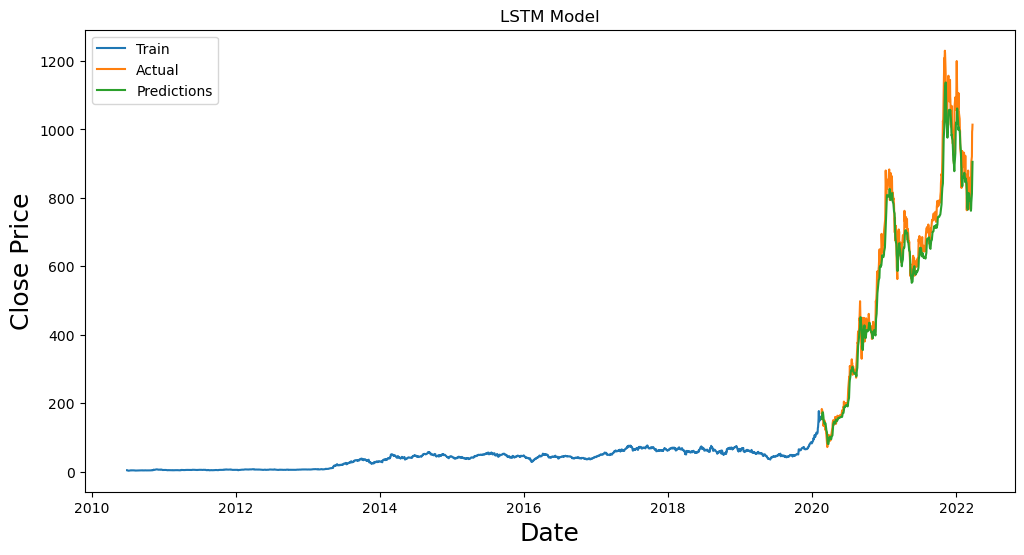

In [71]:
# Visualizing the data
plt.figure(figsize=(12, 6))
plt.title('LSTM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(df['Date'].iloc[:2425],train['Close'])
plt.plot(df['Date'].iloc[2425:],valid[['Close', 'LSTM']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='best')
plt.show()

### GRU

In [73]:
GRU_model = Sequential([
    GRU(units=180, return_sequences=True, input_shape=(train_seq.shape[1],1), activation='tanh'),
    GRU(units=120, return_sequences= False, activation='tanh'),
    Dense(units=60),
    Dense(units=30),
    Dense(units=1)
])
GRU_model.summary()

C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 60, 180)        │        98,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 120)            │       108,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 60)             │         7,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,661 (846.33 KB)

 Trainable params: 216,661 (846.33 KB)

 Non-trainable params: 0 (0.00 B)

In [75]:
GRU_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [77]:
GRU_history = GRU_model.fit(train_seq, train_label, epochs=50, validation_data=(test_seq, test_label))

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 14s 104ms/step - loss: 2.4671e-04 - mean_absolute_error: 0.0101 - val_loss: 0.0013 - val_mean_absolute_error: 0.0253
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 3.0196e-06 - mean_absolute_error: 0.0013 - val_loss: 0.0010 - val_mean_absolute_error: 0.0223
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - loss: 3.2259e-06 - mean_absolute_error: 0.0013 - val_loss: 0.0013 - val_mean_absolute_error: 0.0253
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - loss: 2.6730e-06 - mean_absolute_error: 0.0012 - val_loss: 8.8667e-04 - val_mean_absolute_error: 0.0208
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 1.0720e-05 - mean_absolute_error: 0.0026 - val_loss: 0.0011 - val_mean_absolute_error: 0.0242
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 5.8617e-06 - mean_absolute_error: 0.0018 - val_loss: 0.0010 - val_mean_absolute_error: 0.0230
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 2.6114e-06 - me

In [79]:
# Prediction for test sample
test_predicted2 = GRU_model.predict(test_seq)
test_predicted2[:5]

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


array([[0.13061732],
       [0.13831271],
       [0.1476635 ],
       [0.14710464],
       [0.14695497]], dtype=float32)

In [81]:
# Inverse transform
GRU_test_predicted = scaler.inverse_transform(test_predicted2) # Inversing scaling on predicted data
GRU_test_predicted[:5]

array([[163.3948 ],
       [172.83513],
       [184.30621],
       [183.62062],
       [183.43703]], dtype=float32)

In [83]:
# Inverse transform of test labels
GRU_labels_transform = scaler.inverse_transform(test_label)
GRU_labels_transform[:5]

array([[171.679993],
       [183.483994],
       [179.882004],
       [180.199997],
       [166.757996]])

[Text(0.5, 0, 'Epochs')]

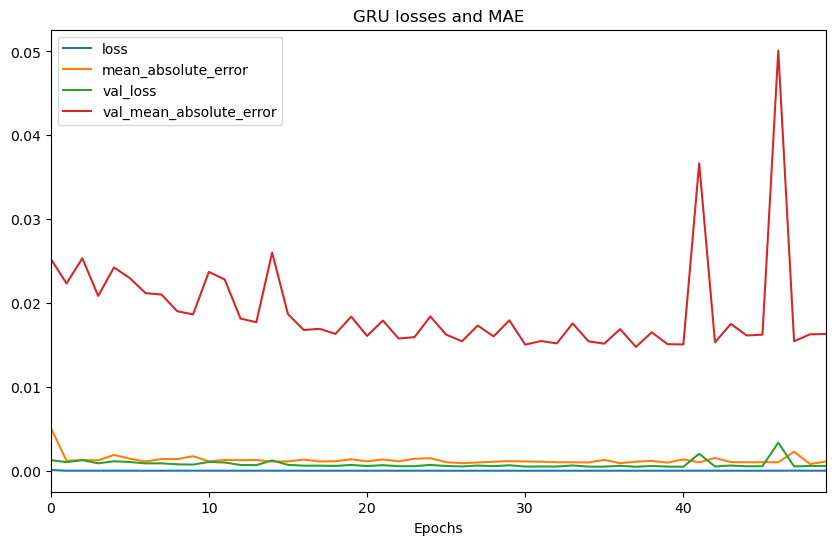

In [85]:
# Plot MAE and losses of val and train data
GRU_losses = pd.DataFrame(GRU_history.history)
ax2 = GRU_losses.plot(figsize=(10,6),title='GRU losses and MAE')
ax2.autoscale(axis='x',tight=True)
ax2.set(xlabel='Epochs')

In [87]:
# Score and error
print(f'Mean Absolute Error: {metrics.mean_absolute_error(GRU_labels_transform, GRU_test_predicted)}')
print(f'Mean Squared Error: {metrics.mean_squared_error(GRU_labels_transform, GRU_test_predicted)}')
print(f'Root Mean Squared Error: {np.sqrt(metrics.mean_squared_error(GRU_labels_transform, GRU_test_predicted))}')
print(f'R2_Score: {metrics.r2_score(GRU_labels_transform, GRU_test_predicted)}')

Mean Absolute Error: 20.004677862836186
Mean Squared Error: 856.1724284122331
Root Mean Squared Error: 29.26042426917684
R2_Score: 0.9900198233134523


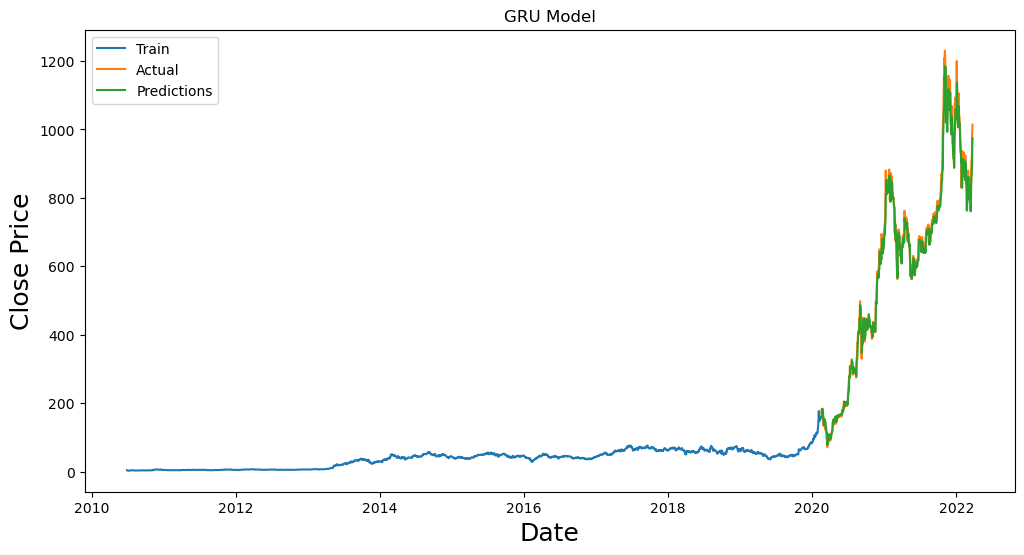

In [89]:
# Create train and val data from DataFrame
train = df.filter(['Close'])[:2425]
valid = df.filter(['Close'])[2425:]
valid['GRU'] = GRU_test_predicted

# Visualizing the data
plt.figure(figsize=(12, 6))
plt.title('GRU Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(df['Date'].iloc[:2425],train['Close'])
plt.plot(df['Date'].iloc[2425:],valid[['Close', 'GRU']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='best')
plt.show()